In [1]:
# تثبيت المكتبات المطلوبة مرة واحدة فقط
!pip install transformers datasets rouge-score sumy bs4 nltk

# حذف الكاش الخاص بـ Huggingface لتفادي المشاكل في التحميل أو التحديث
!rm -rf /root/.cache/huggingface

# استيراد NLTK وتنزيل بيانات punkt (مطلوبة للتقسيم إلى جمل)
import nltk
nltk.download('punkt')


  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 30.3 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=6f04812903126702577d99e9f3614cb20e9d0cf319a0f97dc24ea50cdd3bda35
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
  Created wheel for breadability: filename=breadability-0.1.20-py2.py3-none-any.whl size=21693 sha256=52579c9623bcab143b251fa67e665610fa36c6c8cc022964de0c97f0b8f2d10f
  Stored in directory: /root/.cache/pip/wheels/4d/57/58/7e3d7fedf51fe248b7fcee3df6945ae28638e22cddf01eb92b
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=8c69fd79e7acd7b9a260baa1a439b1c01fc88792d7970d1d6a42a456508ec5cc
  Stored in directory: /roo

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
import pandas as pd

# قراءة ملف CSV باسم "xsum.csv" في DataFrame
df = pd.read_csv("xsum.csv")

# اختيار أول 50 صف فقط لأغراض الاختبار أو العرض السريع
subset = df.head(50)

# عرض أول 5 صفوف من البيانات للتحقق من محتويات الملف

df.head()


,id,input,target,answer_choices,eval_type
0,0,The ex-Reading defender denied fraudulent trad...,Former Premier League footballer Sam Sodje has...,NaN,generation
1,1,Voges was forced to retire hurt on 86 after su...,Middlesex batsman Adam Voges will be out until...,NaN,generation
2,2,Seven photographs taken in the Norfolk country...,The Duchess of Cambridge will feature on the c...,NaN,generation
3,3,"Chris Poole - known as ""moot"" online - created...",Google has hired the creator of one of the web...,NaN,generation
4,4,Four police officers were injured in the incid...,Two teenagers have been charged in connection ...,NaN,generation


In [4]:
from transformers import BartTokenizer, BartForConditionalGeneration

# هنا بنحدد اسم موديل BART اللي هنعمل عليه التلخيص
bart_model_name = "facebook/bart-large-xsum"

# بنجيب أداة تحويل الكلمات لنماذج رقمية (tokenizer) الخاصة بالموديل ده
bart_tokenizer = BartTokenizer.from_pretrained(bart_model_name)

# بنحمل الموديل نفسه اللي هيعمل التلخيص للنصوص
bart_model = BartForConditionalGeneration.from_pretrained(bart_model_name)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.51k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/309 [00:00<?, ?B/s]

In [5]:
from tqdm import tqdm  # مكتبة لعرض شريط تقدم أثناء التكرار

bart_summaries = []  # قائمة لتخزين الملخصات اللي هيتولدوا

# بنلف على كل نص في العمود "input" من الـ subset، ونستخدم tqdm عشان نتابع التقدم
for text in tqdm(subset["input"].tolist(), desc="BART Summaries"):
    # بنحول النص إلى رموز رقمية مناسبة للموديل، مع تحديد طول أقصى 1024 كلمة ورمي الزيادة
    inputs = bart_tokenizer.encode(text, return_tensors="pt", max_length=1024, truncation=True)

    # بنستخدم الموديل لتوليد ملخص، مع إعدادات:
    # max_length: أقصى طول للملخص 60 كلمة
    # min_length: أقل طول للملخص 10 كلمات
    # length_penalty: يعاقب الملخصات القصيرة عشان نخليها أكثر معلوماتية
    # num_beams: عدد المسارات اللي بيتجربها الموديل (4 يعني بيبحث بشكل أعمق)
    # early_stopping: يوقف التوليد لما الملخص يكون مكتمل
    summary_ids = bart_model.generate(
        inputs,
        max_length=60,
        min_length=10,
        length_penalty=2.0,
        num_beams=4,
        early_stopping=True
    )

    # بنرجع الملخص نصي من الرموز الرقمية، ونتجاهل الرموز الخاصة بالموديل
    summary = bart_tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    # بنضيف الملخص لقائمة الملخصات
    bart_summaries.append(summary)

# بنضيف عمود جديد بالملخصات في الـ DataFrame
subset["bart_summary"] = bart_summaries



BART Summaries: 100%|██████████| 50/50 [07:10<00:00,  8.61s/it]
<ipython-input-5-3f164a6c5d48>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["bart_summary"] = bart_summaries


In [6]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# هنا بنجيب أداة تحويل الكلام لأرقام (tokenizer) لموديل T5 العادي
t5_tokenizer = T5Tokenizer.from_pretrained("t5-base")

# وبنجيب موديل T5 نفسه اللي هيشتغل على التوليد (زي التلخيص أو الترجمة)
t5_model = T5ForConditionalGeneration.from_pretrained("t5-base")


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [7]:
t5_summaries = []  # هنا هنحفظ كل الملخصات اللي هنطلعها من موديل T5

# بندور على كل نص في العمود "input" من الـ subset، وشريط التقدم هيورينا الحالة
for text in tqdm(subset["input"].tolist(), desc="T5 Summaries"):
    # بنضيف كلمة "summarize:" قدام النص عشان الموديل يفهم انه التلخيص هو المطلوب
    input_text = "summarize: " + text

    # بنحول النص لأرقام عشان الموديل يفهمه، مع تحديد أقصى طول 512 كلمة
    inputs = t5_tokenizer.encode(input_text, return_tensors="pt", max_length=512, truncation=True)

    # بنطلب من الموديل يولد ملخص بالكلمات اللي عايزينها (بين 10 و 60 كلمة)
    summary_ids = t5_model.generate(
        inputs,
        max_length=60,
        min_length=10,
        length_penalty=2.0,
        num_beams=4,
        early_stopping=True
    )

    # بنرجع النص من الرموز الرقمية، وبنتجاهل الرموز الخاصة اللي مش محتاجينها
    summary = t5_tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    # بنضيف الملخص للقائمة
    t5_summaries.append(summary)

# في الآخر بنضيف عمود جديد فيه الملخصات الناتجة لمجموعة البيانات
subset["t5_summary"] = t5_summaries


T5 Summaries: 100%|██████████| 50/50 [08:41<00:00, 10.42s/it]
<ipython-input-7-345ddb9ef3f5>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["t5_summary"] = t5_summaries


In [10]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer
import nltk  # للتأكد من تحميل الموارد اللازمة

# تحميل المورد المطلوب لتحليل الجمل، اسمه الصحيح هو 'punkt' مش 'punkt_tab'
nltk.download('punkt')
# تحميل مورد NLTK الإضافي المطلوب بواسطة sumy للغة الإنجليزية
nltk.download('punkt_tab')

textrank_summaries = []  # قائمة لحفظ الملخصات

for text in tqdm(subset["input"].tolist(), desc="TextRank Summaries"):
    # بنحول النص لكائن يحلله sumy باستخدام Tokenizer للإنجليزي
    parser = PlaintextParser.from_string(text, Tokenizer("english"))

    # بنستخدم ملخص TextRank
    summarizer = TextRankSummarizer()

    # بنطلب 3 جمل كملخص للنص
    summary = summarizer(parser.document, 3)

    # بنحول الجمل ل string واحدة مفصولة بمسافات
    joined = " ".join(str(sentence) for sentence in summary)

    # بنضيف الملخص للقائمة
    textrank_summaries.append(joined)

# بنضيف عمود جديد بالملخصات في الـ DataFrame
subset["textrank_summary"] = textrank_summaries

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
TextRank Summaries: 100%|██████████| 50/50 [00:01<00:00, 33.94it/s]
<ipython-input-10-148adeaa93bb>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["textrank_summary"] = textrank_summaries


In [11]:
from rouge_score import rouge_scorer

# بنحدد المقاييس اللي هنقيم بيها: rouge-1 (كلمات مفردة)، rouge-2 (كلمات زوجية)، rouge-L (أطول سلسلة متتابعة)
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

def compute_rouge(refs, gens):
    r1, r2, rL = [], [], []  # قوائم لتخزين نتائج كل مقياس
    for ref, gen in zip(refs, gens):
        scores = scorer.score(ref, gen)  # بنحسب المقاييس بين المرجع (ref) والنص المولد (gen)
        r1.append(scores["rouge1"].fmeasure)  # إضافة نتيجة rouge-1
        r2.append(scores["rouge2"].fmeasure)  # إضافة نتيجة rouge-2
        rL.append(scores["rougeL"].fmeasure)  # إضافة نتيجة rouge-L
    return r1, r2, rL  # نرجع كل النتائج

# حساب نتائج Rouge لكل نموذج مقارنة مع النصوص المرجعية في العمود "target"
bart_r1, bart_r2, bart_rL = compute_rouge(subset["target"], subset["bart_summary"])
t5_r1, t5_r2, t5_rL = compute_rouge(subset["target"], subset["t5_summary"])
txt_r1, txt_r2, txt_rL = compute_rouge(subset["target"], subset["textrank_summary"])


In [12]:
def print_rouge(name, r1, r2, rL):
    # بنطبع اسم النموذج
    print(f"\n{name} ROUGE Scores")
    # بنحسب المتوسط لكل مقياس ونطبع النتيجة بأربع أرقام عشرية
    print(f"ROUGE-1: {sum(r1)/len(r1):.4f}")
    print(f"ROUGE-2: {sum(r2)/len(r2):.4f}")
    print(f"ROUGE-L: {sum(rL)/len(rL):.4f}")

# عرض النتائج لكل موديل حسب المقاييس اللي حسبناها
print_rouge("BART", bart_r1, bart_r2, bart_rL)
print_rouge("T5", t5_r1, t5_r2, t5_rL)
print_rouge("TextRank", txt_r1, txt_r2, txt_rL)



BART ROUGE Scores
ROUGE-1: 0.4821
ROUGE-2: 0.2541
ROUGE-L: 0.4075

T5 ROUGE Scores
ROUGE-1: 0.1975
ROUGE-2: 0.0366
ROUGE-L: 0.1425

TextRank ROUGE Scores
ROUGE-1: 0.1633
ROUGE-2: 0.0276
ROUGE-L: 0.1107


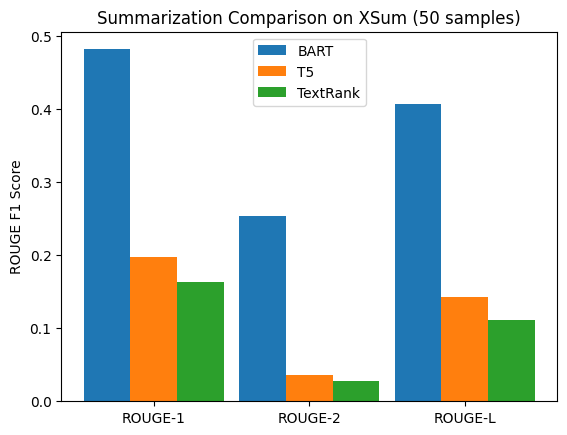

In [13]:
import matplotlib.pyplot as plt

labels = ["ROUGE-1", "ROUGE-2", "ROUGE-L"]
x = range(len(labels))

plt.bar([i - 0.3 for i in x], [sum(bart_r1)/len(bart_r1), sum(bart_r2)/len(bart_r2), sum(bart_rL)/len(bart_rL)], width=0.3, label="BART")
plt.bar(x, [sum(t5_r1)/len(t5_r1), sum(t5_r2)/len(t5_r2), sum(t5_rL)/len(t5_rL)], width=0.3, label="T5")
plt.bar([i + 0.3 for i in x], [sum(txt_r1)/len(txt_r1), sum(txt_r2)/len(txt_r2), sum(txt_rL)/len(txt_rL)], width=0.3, label="TextRank")

plt.xticks(x, labels)
plt.ylabel("ROUGE F1 Score")
plt.title("Summarization Comparison on XSum (50 samples)")
plt.legend()
plt.show()


In [14]:
subset.to_csv("xsum_bart_t5_textrank_comparison.csv", index=False)
print("Saved to xsum_bart_t5_textrank_comparison.csv")


Saved to xsum_bart_t5_textrank_comparison.csv
